In [1]:
%run state_abbrevs.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.ticker import FuncFormatter

### Read in DFs and Clean

In [3]:
agg_2019 = pd.read_csv('/Volumes/MW-4/_HW-Ji/19/19-agg_year.csv')
agg_2020 = pd.read_csv('/Volumes/MW-4/_HW-Ji/20/20-agg_year.csv')

In [111]:
agg_2020['week_'] = pd.to_datetime(agg_2020['week'], yearfirst=True)

In [115]:
agg_2019['week_'] = pd.to_datetime(agg_2019['week'], yearfirst=True)
agg_2020['week_'] = pd.to_datetime(agg_2020['week'], yearfirst=True)

In [116]:
county_city_df = pd.read_csv('../input_data/simplemaps_uscities_basicv1.73/uscities.csv')

In [117]:
socio_dem = pd.read_csv('../input_data/cty_covariates.csv')

In [118]:
fips_state = pd.read_excel('../input_data/state-geocodes-v2017.xlsx')

### Merge Socio-Dem County Data on FIPS to bring in State Name

In [119]:
socio_dem_df = pd.merge(socio_dem, fips_state, left_on="state", right_on="State (FIPS)")
socio_dem_df = socio_dem_df.rename(columns = {'Name': 'state_name'})

In [120]:
socio_dem_df["state_ID"] = socio_dem_df["state_name"].apply(lambda x: us_state_abbrev.get(x))

### Bring city into park data -- only have city but socio-dem data only has county

In [121]:
filt_agg_2019 = agg_2019[['park_name', 'feattype', 'city', 'region','raw_visit_counts', 'week']]
filt_agg_2020 = agg_2020[['park_name', 'feattype', 'city', 'region','raw_visit_counts', 'week']]

In [122]:
filt_county_city_df = county_city_df[['city','state_id', 'county_name','state_name','county_fips']]

In [123]:
county_city_2019 = (filt_agg_2019.merge(filt_county_city_df, left_on=["city", "region"]
                                              ,right_on=["city", "state_id"], how="inner"))
county_city_2020 = (filt_agg_2020.merge(filt_county_city_df, left_on=["city", "region"]
                                              ,right_on=["city", "state_id"], how="inner"))

In [124]:
county_city_2020.head()

,park_name,feattype,city,region,raw_visit_counts,week,state_id,county_name,state_name,county_fips
0,10 Acre Park,Local park,Beeville,TX,30,20-01-06,TX,Bee,Texas,48025
1,Alta Vista Park,Local park,Beeville,TX,20,20-01-06,TX,Bee,Texas,48025
2,Flournoy Park,Local park,Beeville,TX,70,20-01-06,TX,Bee,Texas,48025
3,Kohler Park,Local park,Beeville,TX,126,20-01-06,TX,Bee,Texas,48025
4,10 Acre Park,Local park,Beeville,TX,20,20-01-13,TX,Bee,Texas,48025


In [148]:
filt_agg_2020

,park_name,feattype,city,region,raw_visit_counts,week
0,10 Acre Park,Local park,Beeville,TX,30,20-01-06
1,1000 Islands Conservancy Zone,Local park,Kaukauna,WI,41,20-01-06
2,109th St Recreation Center Park,Local park,Los Angeles,CA,55,20-01-06
3,10th Ave & Clement Mini Park,Local park,San Francisco,CA,77,20-01-06
4,10th St Park,Local park,Paris,TX,7,20-01-06
...,...,...,...,...,...,...
1261081,Zurrie M. Malone Park,Local park,Houston,TX,34,20-11-23
1261082,Zussman Playground,Local park,Detroit,MI,37,20-11-23
1261083,Zwaanendael Park,Local park,Lewes,DE,6,20-11-23
1261084,sec20 Park,Local park,Broomfield,CO,17,20-11-23


### How many parks span multiple cities?

In [165]:
len(filt_agg_2020[filt_agg_2020['city'].str.contains(",")].reset_index(drop=True))

31780

In [166]:
len(filt_agg_2019[filt_agg_2019['city'].str.contains(",")].reset_index(drop=True))

35805

### Merge county demographic df with parks df and then plot weekly visit averages by demographic of the park county -- 2019 and 2020 as separate graphs

In [167]:
def plot_county_dems(majority_df, year_df):
    
    merged_race_df = (year_df.merge(majority_df, left_on=['county_name','region'],
                                               right_on=["czname", "state_ID"], how="inner"))
    
    week_visits_race =  merged_race_df.groupby('week',as_index=False)['raw_visit_counts'].mean()
    
    to_plot_df = week_visits_race.copy()
    to_plot_df.set_index('week', inplace=True)
    
    return to_plot_df

In [171]:
def plot_race_shares(to_plot_B, to_plot_W, to_plot_H, to_plot_A, label1, label2, label3, label4,x):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.set_xticks(range(0,len(to_plot_B.index)))
    to_plot_B.plot(kind="line", color="green",ax=ax, rot=90, label=label1)
    to_plot_W.plot(kind="line", color="red",ax=ax, rot=90, label=label2)
    to_plot_H.plot(kind="line", color="orange",ax=ax, rot=90, label=label3)
    to_plot_A.plot(kind="line", color="blue",ax=ax, rot=90, label=label4)
    
    
    plt.xlabel('week', fontsize=14)
    plt.ylabel('Average Raw Visit Count', fontsize=14)
    
    if (x==1):
        plt.title("2019 Weekly Visit Averages by Demographics of Park County", fontsize=16)
    elif (x==2):
        plt.title("2020 Weekly Visit Averages by Demographics of Park County", fontsize=16)
        
    
    plt.legend([label1, label2,label3,label4], frameon=False)


In [172]:
race_plot_dfs = []

years = [county_city_2019, county_city_2020]

cols = ['share_black2010','share_white2010', 'share_hisp2010','share_asian2010']

for year in years:
    for col in cols:
        majority_race_df = socio_dem_df[socio_dem_df[col]>=socio_dem_df[col].mean()]
        to_plot_df = plot_county_dems(majority_race_df, year)
        race_plot_dfs.append(to_plot_df)

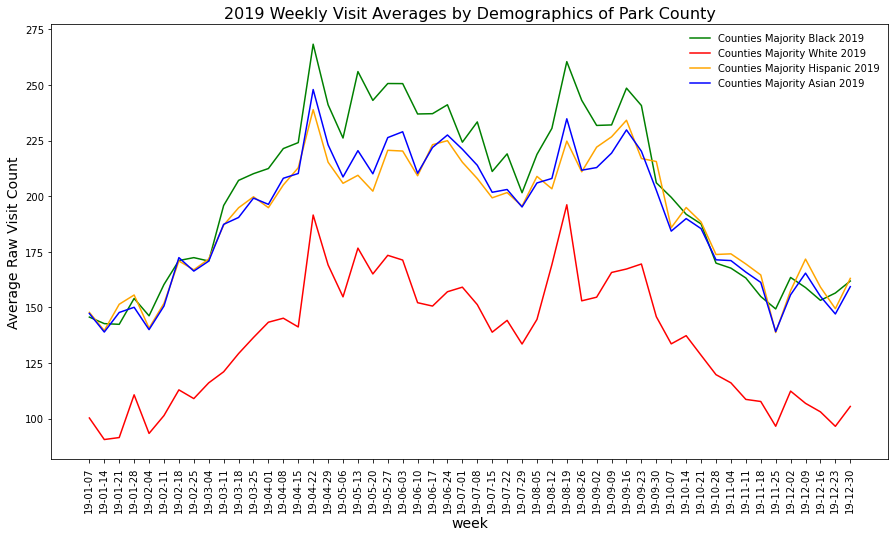

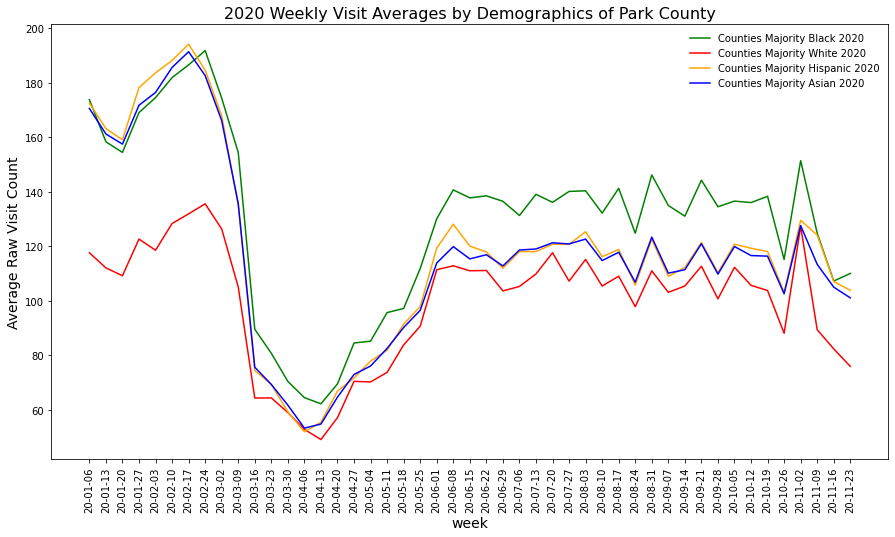

In [173]:
labels = ['Counties Majority Black 2019','Counties Majority White 2019',
          'Counties Majority Hispanic 2019', 'Counties Majority Asian 2019',
            'Counties Majority Black 2020', 'Counties Majority White 2020',
             'Counties Majority Hispanic 2020','Counties Majority Asian 2020']  

x =0
for i in range(0,len(race_plot_dfs),4):
    to_plot_B = race_plot_dfs[i]
    to_plot_W = race_plot_dfs[i+1]
    to_plot_H = race_plot_dfs[i+2]
    to_plot_A = race_plot_dfs[i+3]

    label1 = labels[i]
    label2 = labels[i+1]
    label3 = labels[i+2]
    label4 = labels[i+3]
    x+=1
    plot_race_shares(to_plot_B, to_plot_W, to_plot_H, to_plot_A, label1, label2, label3, label4,x)

### Repeat the plots above but plot 2019 and 2020 on the same plot and separate by race

In [189]:
for i in range(0,len(race_plot_dfs)//2,4):
    to_plot_B_19 = race_plot_dfs[i]
    to_plot_W_19 = race_plot_dfs[i+1]
    to_plot_H_19 = race_plot_dfs[i+2]
    to_plot_A_19 = race_plot_dfs[i+3]

In [190]:
for i in range(len(race_plot_dfs)//2, len(race_plot_dfs),4):
    to_plot_B_20= race_plot_dfs[i]
    to_plot_W_20 = race_plot_dfs[i+1]
    to_plot_H_20 = race_plot_dfs[i+2]
    to_plot_A_20 = race_plot_dfs[i+3]

In [200]:
long_index_B =  to_plot_B_19.append(to_plot_B_20)
long_index_W = to_plot_W_19.append(to_plot_W_20)

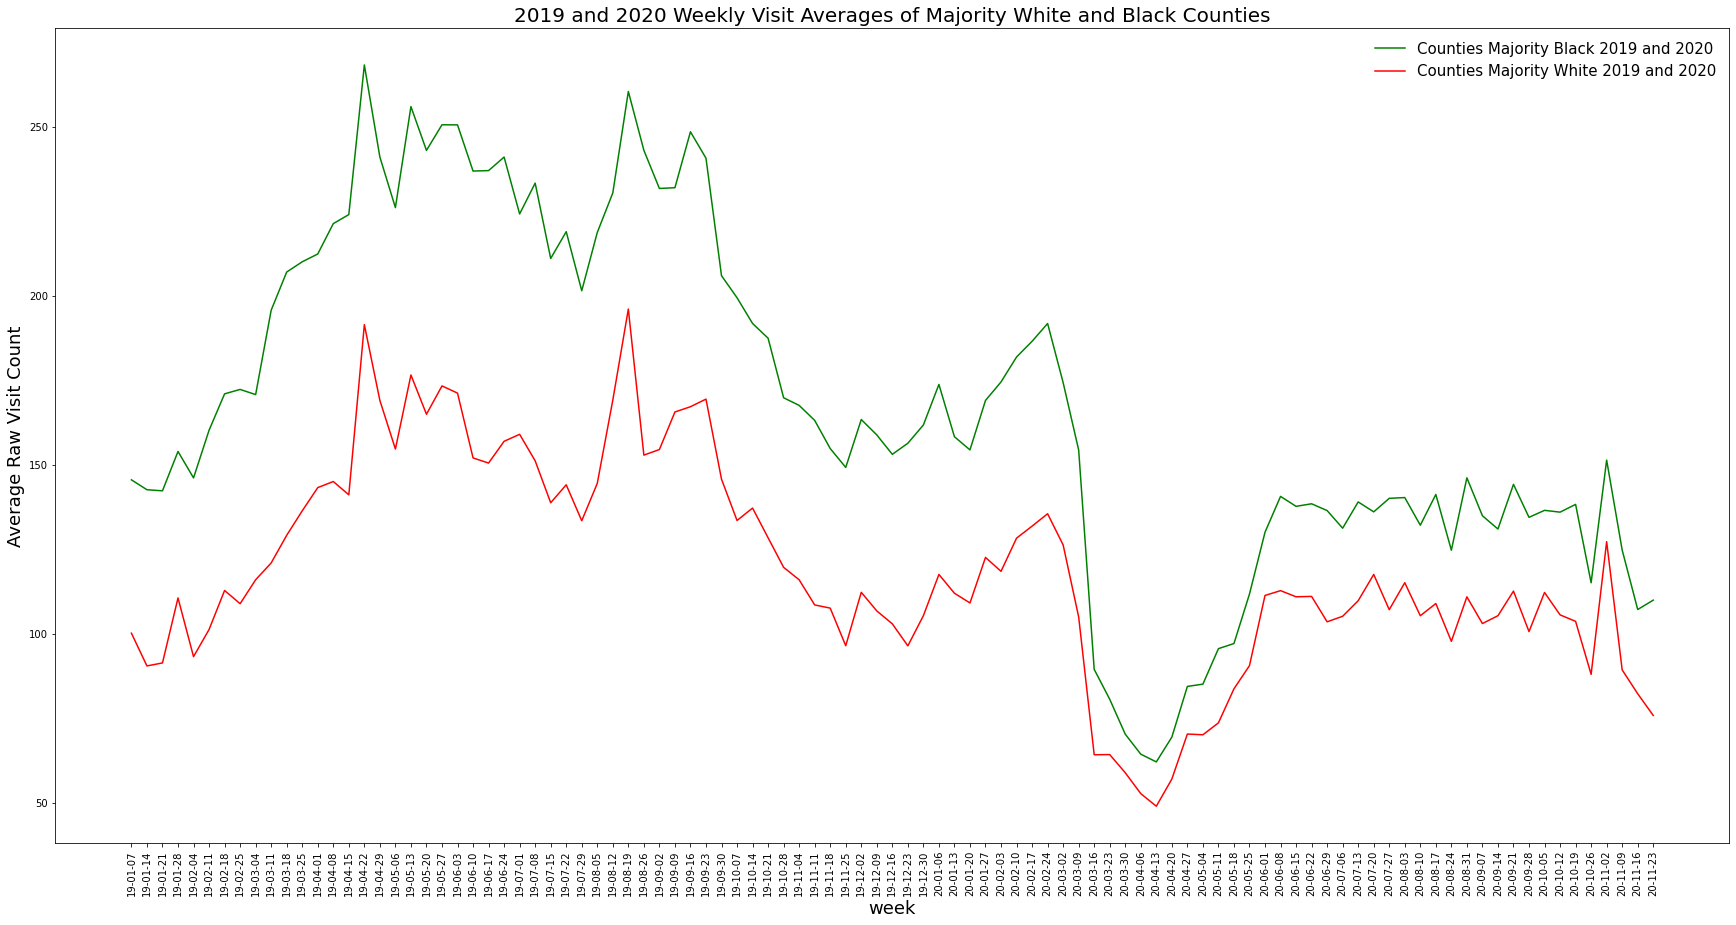

In [207]:
fig, ax = plt.subplots(figsize=(30,15))

ax.set_xticks(range(0,len(long_index_B.index)))

label1 = 'Counties Majority Black 2019 and 2020'
label2 = 'Counties Majority White 2019 and 2020'

long_index_B.plot(kind="line", color="green",ax=ax, rot=90, label=label1)
long_index_W.plot(kind="line", color="red",ax=ax, rot=90, label=label2)

plt.xlabel('week', fontsize=18)
plt.ylabel('Average Raw Visit Count', fontsize=18)
plt.title("2019 and 2020 Weekly Visit Averages of Majority White and Black Counties", fontsize=20)


plt.legend([label1, label2], fontsize=15, frameon=False)

In [208]:
long_index_H =  to_plot_H_19.append(to_plot_H_20)
long_index_A = to_plot_A_19.append(to_plot_A_20)

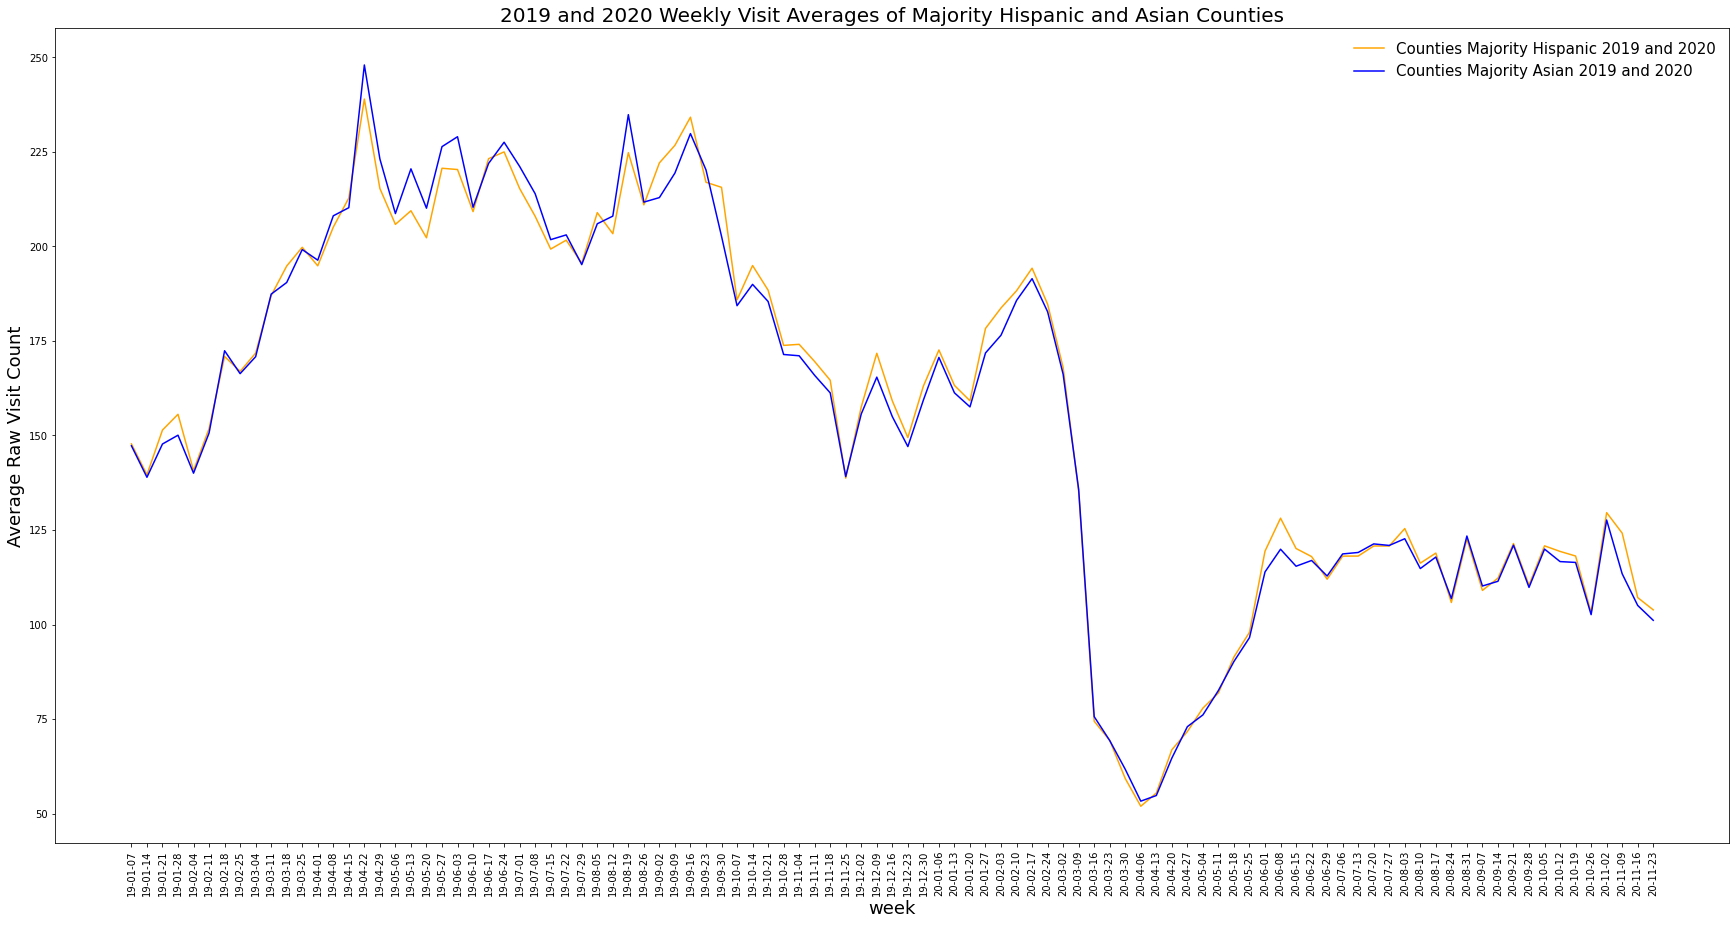

In [210]:
fig, ax = plt.subplots(figsize=(30,15))

ax.set_xticks(range(0,len(long_index_H.index)))

label1 = 'Counties Majority Hispanic 2019 and 2020'
label2 = 'Counties Majority Asian 2019 and 2020'

long_index_H.plot(kind="line", color="orange",ax=ax, rot=90, label=label1)
long_index_A.plot(kind="line", color="blue",ax=ax, rot=90, label=label2)

plt.xlabel('week', fontsize=18)
plt.ylabel('Average Raw Visit Count', fontsize=18)
plt.title("2019 and 2020 Weekly Visit Averages of Majority Hispanic and Asian Counties", fontsize=20)

plt.legend([label1, label2], fontsize=15, frameon=False)